# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure OpenAI Configuration
AOAI_ENDPOINT=your_azure_openai_endpoint
AOAI_KEY=your_azure_openai_api_key
AOAI_API_VERSION=2024-02-01  # Optional, defaults to this value

# Model Deployment Names
reasoningModel=your_reasoning_model_deployment_name  # e.g., o1-preview
chatModel=your_chat_model_deployment_name  # e.g., gpt-4o

# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Bing Search Agent (pre-created in Azure AI Foundry)
bingSearchAgentID=your_bing_search_agent_id
BING_CONNECTION_NAME=your_bing_connection_name  # Only needed if creating agent inline
```

**Note:** This notebook creates agents inline using the OpenAI Agents SDK, except for the Bing Search agent which must be pre-created in Azure AI Foundry. If you haven't created the Bing Search agent yet, uncomment and run the agent creation cell below.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating the Bing Search Agent (One-time Setup)

The following cell will **create** an **Azure AI Agent** with Bing Search capabilities. You only need to run this cell **once** to create the agent, then save its ID to your `.env` file as `bingSearchAgentID`.

If you already have a Bing Search agent created, skip this cell and use the next cell to update its instructions instead.

In [5]:
# from azure.ai.agents.models import BingGroundingTool

# import datetime
# current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# bing_connection = project_client.connections.get(
#     name=os.getenv("BING_CONNECTION_NAME")
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="bingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions=f"""
# You are a helpful research assistant.

# Today's date is {current_date}.

# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results.
#     """.strip()
# )

### Updating Existing Bing Search Agent

If you already have a Bing Search agent (with its ID in your `.env` file), run this cell to update its instructions with today's date. This ensures the agent has current date awareness for time-sensitive queries.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-11-28.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


### Creating OpenAI Agents

The following agents are created inline using the OpenAI Agents SDK. These agents handle planning, summarization, research synthesis, and peer review. They are created fresh each time you run the notebook.

In [7]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)


**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

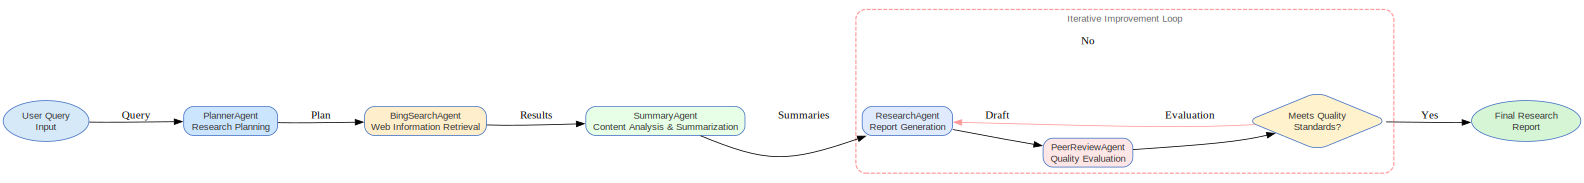

In [9]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [10]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'Definition of deep learning in AI',
 'What is generative AI?',
 'Fundamental differences between classical ML, deep learning, and generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [13]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [05:04<00:00, 60.99s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 20

Actually total search queries: 20



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [15]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 5/5 [01:27<00:00, 17.54s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [16]:
plan.final_output

ResearchPlan(query='What are the differences between classical machine learning, deep learning and generative AI?', objective='To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, focusing on their definitions, methodologies, applications, strengths, limitations, and interrelationships.', success_criteria=['Clear definitions and distinctions between classical machine learning, deep learning, and generative AI are established.', 'Key methodologies and algorithms for each approach are described and compared.', 'Real-world applications and use cases for each approach are identified and contrasted.', 'Strengths, limitations, and challenges of each approach are articulated.', 'Relationships and overlaps between classical machine learning, deep learning, and generative AI are explained.'], related_topics=['Supervised vs. unsupervised learning', 'Neural network architectures', 'Ethics in artificial intelligence'], research_tasks=[ResearchTask(id

In [17]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan.final_output, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [18]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [19]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI

## Introduction

Artificial intelligence (AI) has undergone rapid and transformative evolution in recent decades, giving rise to a spectrum of computational paradigms that have redefined how machines learn, perceive, and create. Among these, classical machine learning (ML), deep learning (DL), and generative AI (GenAI) stand out as the most influential and widely adopted approaches. Each paradigm is characterized by distinct methodologies, technical requirements, and application domains, yet they are deeply interconnected, forming a continuum of increasing abstraction, complexity, and capability. This report provides an exceptionally comprehensive analysis of these three pillars of modern AI, examining their definitions, fundamental concepts, key algorithms, real-world applications, strengths, limitations, and the nuanced relationships that bind them. Through rigorous synthesis and comparative evaluation, the report aims to elucidate the unique contributions and challenges of each approach, offering insights into their current impact and future trajectories.

## 1. Definitions and Fundamental Concepts

### 1.1 Classical Machine Learning

Classical machine learning refers to a subset of AI algorithms that utilize statistical techniques to uncover patterns and relationships within data, typically structured in tabular formats. These algorithms, including Support Vector Machines (SVM), Decision Trees, Logistic Regression, Naive Bayes, K-Nearest Neighbors (KNN), and Linear Regression, are designed to perform optimally within well-defined problem scopes and are highly interpretable. The hallmark of classical ML is manual feature extraction, which requires domain expertise to identify relevant input variables. This paradigm excels in scenarios where data is limited and transparency is paramount, making it suitable for predictive modeling tasks such as spam detection, recommendation systems, and risk assessment [1][2][6].

Classical ML is generally categorized into three primary learning paradigms:

- **Supervised Learning:** Models are trained on labeled datasets to map inputs to outputs for prediction or classification. Examples include regression and classification tasks.
- **Unsupervised Learning:** The goal is to uncover hidden patterns or groupings in unlabeled data, such as clustering and dimensionality reduction.
- **Reinforcement Learning:** Agents learn optimal behaviors through interactions with an environment, guided by rewards or penalties to maximize cumulative outcomes.

Key technical concepts include overfitting (where a model captures noise rather than signal, reducing generalizability), the bias-variance trade-off (balancing model simplicity against flexibility), and robust model evaluation techniques like cross-validation. Tom Mitchell’s formal definition encapsulates the essence of machine learning: a computer program improves its performance at a task through experience, as measured by a specific metric [13].

### 1.2 Deep Learning

Deep learning is a specialized branch of machine learning that introduces multi-layered artificial neural networks inspired by the human brain’s structure. These networks, often comprising dozens or hundreds of layers, automatically extract and hierarchically learn features from raw, unstructured data such as images, audio, and text. Architectures like convolutional neural networks (CNNs) excel at image processing, while recurrent neural networks (RNNs) handle sequential data. Deep learning models require vast datasets and substantial computational resources, typically utilizing GPUs or TPUs for efficient training. Unlike classical ML, deep learning obviates the need for manual feature engineering, instead discovering intricate data representations autonomously. This capability underpins state-of-the-art AI applications in computer vision, natural language processing, speech recognition, and autonomous systems. However, the complexity and opacity of deep neural networks result in lower interpretability compared to classical ML models [3][4][7][8][13].

### 1.3 Generative AI

Generative AI represents a transformative leap in artificial intelligence, focusing on the autonomous creation of new content—text, images, music, and more—by learning the statistical structures and patterns within massive datasets. GenAI models, often built upon deep learning architectures such as Generative Adversarial Networks (GANs) and transformers (e.g., GPT), are distinguished by their ability to synthesize novel outputs that are not mere replicas but share statistical properties with their training data. GANs employ a dual-network approach, with a generator producing new samples and a discriminator evaluating their authenticity, while transformers utilize attention mechanisms to model complex dependencies in data. Generative AI is fundamentally different from discriminative AI, which classifies or labels data; GenAI creates entirely new data instances, enabling applications in art, literature, music, and even drug discovery. The technology’s rapid evolution has sparked philosophical and policy debates about its role in augmenting human creativity and its broader societal implications [5][9][10][11][12][13].

### 1.4 Comparative Foundations

A comparative analysis highlights several foundational distinctions: classical ML operates primarily on structured data with manual feature extraction, deep learning automates feature learning from unstructured data via multi-layered networks, and generative AI leverages advanced deep learning architectures to produce new data, pushing the boundaries of machine creativity. Data requirements escalate from classical ML (small to moderate datasets) to deep learning and generative AI (large to very large datasets), with interpretability decreasing as model complexity increases. While classical ML remains favored for its transparency and ease of implementation, deep learning and generative AI drive breakthroughs in perception, recognition, and creative synthesis [7].

### 1.5 Visualization: Hierarchical Breakdown

```mermaid
graph TD
    AI[Artificial Intelligence]
    ML[Machine Learning]
    DL[Deep Learning]
    GenAI[Generative AI]
    AI --> ML
    ML --> DL
    DL --> GenAI
```

This hierarchical diagram illustrates the nested relationship, with each paradigm building upon the capabilities of the previous.

## 2. Key Methodologies and Algorithms

### 2.1 Classical Machine Learning Algorithms

Classical machine learning employs a suite of well-established algorithms for tasks such as classification, regression, clustering, and dimensionality reduction. Supervised learning algorithms like linear regression and logistic regression are pivotal for predicting continuous and categorical outcomes, respectively. Linear regression models relationships using a straight line, making it ideal for applications such as house price prediction, while logistic regression estimates the probability of binary events, such as spam detection. Decision trees, which split data based on feature values, offer intuitive models for both classification and regression, and serve as the basis for ensemble methods like random forests, which aggregate predictions from multiple trees to enhance accuracy and mitigate overfitting [1][10][14].

Support Vector Machines (SVMs) are robust algorithms for both classification and regression, excelling in scenarios with outliers by identifying optimal hyperplanes for class separation. K-Nearest Neighbors (KNN) provides a non-parametric approach, assigning labels based on the majority among k-nearest data points, and is valued for its simplicity and versatility. Naive Bayes, grounded in Bayes’ theorem, is particularly effective for text classification tasks where feature independence is assumed, offering computational efficiency. Unsupervised learning methodologies include K-means clustering, which partitions data into k clusters based on proximity to centroids, and Principal Component Analysis (PCA), a dimensionality reduction technique that preserves variance for improved visualization and noise reduction. The Apriori algorithm is instrumental in association rule learning, uncovering frequent itemsets in transactional data—a cornerstone for market basket analysis [15].

These classical algorithms are characterized by moderate data requirements, manual feature engineering, high interpretability, and relatively low computational cost. They are foundational for structured/tabular data applications such as fraud detection, customer segmentation, and spam filtering. Performance enhancement strategies like cross-validation, regularization, and ensemble methods are routinely employed to prevent overfitting and improve generalization [14][16].

### 2.2 Deep Learning Architectures

Deep learning marks a paradigm shift by leveraging neural networks with multiple layers—enabling automatic extraction and transformation of features from raw, often unstructured data. Convolutional Neural Networks (CNNs) dominate image and spatial data analysis, utilizing convolutional layers to learn hierarchical spatial features, and are central to computer vision tasks like image classification and object detection. Recurrent Neural Networks (RNNs), along with their advanced variants Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs), are tailored for sequential data, excelling in speech recognition, time series analysis, and natural language processing by maintaining temporal dependencies [2][3][17].

Transformers, introduced for NLP, have revolutionized sequence modeling through self-attention mechanisms, enabling the capture of long-range dependencies and underpinning large language models (LLMs) such as GPT and BERT. Generative Adversarial Networks (GANs) employ a dual-network approach—generator and discriminator—to synthesize realistic data, particularly images and videos. Autoencoders and Variational Autoencoders (VAEs) facilitate unsupervised learning, dimensionality reduction, and generative modeling by compressing and reconstructing data, with VAEs introducing probabilistic latent spaces for enhanced generative capabilities. Deep Belief Networks (DBNs) and Graph Neural Networks (GNNs) extend deep learning to unsupervised feature extraction and graph-structured data, respectively, supporting applications in social network analysis and molecular chemistry [17][18].

Deep learning methodologies require large datasets and significant computational resources (GPUs/TPUs), with optimization algorithms like Stochastic Gradient Descent (SGD), Adam, and RMSprop driving efficient training. Techniques such as batch normalization and residual connections stabilize and accelerate learning, enabling the construction of deeper networks. Training paradigms like self-supervised learning, federated learning, and deep reinforcement learning further expand the versatility and privacy of deep learning models [19].

### 2.3 Generative AI Techniques

Generative AI builds upon deep learning, employing advanced architectures to create novel content—text, images, audio, and more. Key algorithms include GANs, VAEs, diffusion models, and transformer-based models. Diffusion models, for instance, iteratively refine random noise into structured outputs, achieving state-of-the-art results in high-fidelity image synthesis (e.g., DALL·E 3, Stable Diffusion). Transformer-based architectures, originally developed for NLP, now power multi-modal generative models capable of handling text, image, and audio simultaneously. Supporting concepts such as prompt engineering, RLHF (Reinforcement Learning from Human Feedback), and Retrieval-Augmented Generation (RAG) enhance the quality, safety, and factuality of generative outputs [7][12][19].

The deployment and scaling of these methodologies are facilitated by frameworks like PyTorch, TensorFlow, and Hugging Face Transformers, as well as specialized tools for generative AI applications (LangChain, LangGraph, LlamaIndex). Generative AI models demand massive datasets and computational power, but they enable transformative applications in chatbots, creative arts, code generation, and scientific discovery [19].

### 2.4 Visualization: Comparison Table of Algorithms

| Approach             | Key Algorithms/Architectures         | Data Type         | Feature Engineering | Interpretability | Computational Demand |
|----------------------|--------------------------------------|-------------------|--------------------|------------------|---------------------|
| Classical ML         | Linear Regression, SVM, Decision Trees, KNN, Naive Bayes, Random Forest | Structured        | Manual             | High             | Low                 |
| Deep Learning        | CNN, RNN, LSTM, Transformer, GAN, Autoencoder, VAE, GNN | Unstructured      | Automatic          | Low              | High                |
| Generative AI        | GAN, VAE, Diffusion Models, Transformer (LLMs) | Unstructured      | Automatic          | Very Low         | Very High           |

## 3. Applications and Use Cases

### 3.1 Classical Machine Learning Applications

Classical machine learning is foundational in industrial automation and decision-making, particularly where structured data is abundant. Predictive maintenance is a flagship application, where ML models analyze sensor and operational data from industrial equipment to forecast failures, minimizing downtime and maintenance costs—a practice widely adopted in manufacturing and heavy industry. Quality control leverages ML algorithms for real-time defect detection and standards compliance, using pattern recognition and anomaly detection on data from cameras and sensors. Supply chain optimization benefits from ML’s ability to forecast demand, manage inventory, and suggest optimal logistics routes, even adapting to disruptions like extreme weather. Process monitoring and optimization see ML models automatically adjusting operational parameters to maximize efficiency, reduce energy consumption, and minimize waste, especially in chemical and manufacturing sectors [20][21][22].

Soft sensing employs ML to estimate hard-to-measure variables (e.g., product quality) from readily available process data, providing cost-effective, real-time insights without expensive hardware. In customer-facing domains such as retail and finance, ML powers chatbots, recommendation engines, and personalized marketing, enhancing customer experience and driving sales. Financial institutions use ML for real-time fraud detection and risk management by analyzing transaction patterns and flagging anomalies. Energy management applications include predicting consumption, optimizing usage, and integrating renewables into the grid. These use cases typically rely on supervised learning (regression, classification), unsupervised learning (clustering, anomaly detection), and reinforcement learning, with adoption accelerating as IoT devices proliferate and data volumes grow [23][24].

### 3.2 Deep Learning Applications

Deep learning, a subset of ML utilizing multi-layered neural networks, is transformative in domains requiring analysis of complex, unstructured data. In computer vision, convolutional neural networks (CNNs) are pivotal for medical imaging, enabling early and accurate detection of tumors, fractures, and other anomalies in X-rays, MRIs, and CT scans—often surpassing traditional diagnostic methods. Autonomous vehicles depend on DL for processing sensor and camera data to achieve object detection, lane keeping, and pedestrian recognition, facilitating safe navigation. Security and surveillance systems use DL for real-time facial recognition and object tracking in public spaces. Natural language processing (NLP) applications include virtual assistants (e.g., Siri, Alexa), customer service chatbots, text summarization, and sentiment analysis, all powered by DL’s ability to interpret speech, understand context, and generate coherent responses [25][26][27].

Speech recognition technologies enable voice typing, dictation, and automated transcription for meetings and events. Recommendation systems in media and e-commerce (Netflix, YouTube, Amazon) analyze user behavior to personalize content and product suggestions. In healthcare, DL models analyze electronic health records, genetic data, and biometrics to predict patient outcomes and personalize treatment plans, while also accelerating drug discovery by simulating molecular interactions. Financial services utilize DL for credit risk assessment and fraud detection, outperforming traditional statistical models. Agriculture benefits from DL frameworks that analyze environmental data to optimize crop management. Cybersecurity applications include real-time threat detection through analysis of network traffic and system logs. DL’s superiority lies in its capacity to extract hierarchical features from vast datasets, making it indispensable for tasks involving images, text, and audio [28][29][30].

### 3.3 Generative AI Applications

Generative AI, the latest evolution in AI, utilizes advanced deep learning architectures (notably transformers) to create new content—text, images, audio, code—based on learned patterns. In healthcare, generative AI assists radiologists by interpreting complex scans and spotting anomalies, and accelerates drug discovery by predicting molecular interactions, reducing failed trials and time-to-market. Retail and e-commerce leverage generative AI for personalized shopping experiences, visual product searches, and operational efficiency, moving beyond experimentation to deliver tangible business value. Financial services benefit from AI-generated personalized advice, automated document processing, and enhanced fraud detection through synthesis of transaction data [31][32][33].

Marketing and advertising are transformed by AI-generated content—copy, images, videos, jingles—and hyper-personalization of messaging at scale. Manufacturing applications include product design, supply chain optimization, automated quality control, and synthetic data generation for model training. In education, generative AI produces custom learning materials and automates administrative tasks, enabling personalized learning. Entertainment and content creation see AI generating art, music, videos, and game assets, streamlining creative workflows and enabling new forms of expression. Energy and sustainability sectors use generative AI for predictive analytics, grid optimization, and sustainable agriculture insights. Customer service is enhanced by AI-powered chatbots and virtual assistants generating personalized responses. Generative AI’s economic impact is substantial, with estimates of up to $4.4 trillion in annual global value, though most organizations are still in early adoption stages, with high performers aligning AI with strategic goals for maximum impact [34][35][36].

### 3.4 Visualization: Impact Assessment Matrix

| Industry          | Classical ML Applications           | Deep Learning Applications         | Generative AI Applications         |
|-------------------|-------------------------------------|------------------------------------|------------------------------------|
| Healthcare        | Predictive analytics, risk scoring  | Medical imaging, EHR analysis      | Drug discovery, scan interpretation|
| Manufacturing     | Predictive maintenance, QC          | Defect detection, process optimization | Product design, synthetic data    |
| Retail/E-commerce | Recommendation engines, fraud detection | Personalized recommendations, demand forecasting | Visual search, content generation |
| Finance           | Credit scoring, fraud detection     | Risk assessment, transaction analysis | Automated advice, document synthesis|
| Marketing         | Customer segmentation, campaign analysis | Sentiment analysis, personalization | Content creation, hyper-personalization|
| Education         | Student performance prediction      | Adaptive learning, grading         | Custom materials, automated tutoring|
| Entertainment     | User analytics, recommendation      | Image/video analysis, music generation | Art/music/video creation, game assets|
| Energy            | Usage prediction, grid optimization | Sensor data analysis, anomaly detection | Predictive analytics, sustainability insights|

## 4. Strengths, Limitations, and Challenges

### 4.1 Classical Machine Learning

Classical machine learning is characterized by its ease of implementation, efficiency, and interpretability. Algorithms such as decision trees, logistic regression, and support vector machines are straightforward to design, debug, and deploy, requiring less computational power and training time, especially for small or structured datasets. Their interpretability—particularly in models like decision trees and linear regression—facilitates transparency and stakeholder communication, which is crucial in regulated domains such as finance and healthcare. Classical ML also boasts lower data requirements, performing well with modestly sized datasets, and is cost-effective, often running on standard hardware without the need for GPUs or TPUs. Its specialization for structured, tabular data makes it indispensable in domains where data is well-organized [37][38][39].

However, classical ML faces significant limitations and challenges. Its adaptability and scalability are restricted; models are often tailored for specific tasks and require manual feature engineering and reprogramming to generalize to new or more complex scenarios. The inability to handle unstructured data—such as images, audio, and free-form text—limits its applicability in domains where such data predominates. For tasks involving intricate patterns or relationships, classical ML typically underperforms compared to deep learning, and its reliance on manual feature engineering can be labor-intensive and dependent on domain expertise. Additionally, classical algorithms lack dynamic learning capabilities, necessitating retraining with new data to adapt to changing environments [40][41].

### 4.2 Deep Learning

Deep learning has revolutionized fields like image recognition, natural language processing, and autonomous systems through its ability to learn complex, hierarchical representations from large, unstructured datasets. Models such as convolutional neural networks (CNNs), recurrent neural networks (RNNs), and transformers excel in extracting intricate patterns, automating feature learning, and achieving state-of-the-art accuracy in challenging domains. Deep learning enables automation of predictive analytics, reducing manual effort and improving efficiency [42][43].

Yet, deep learning’s limitations are pronounced. Its performance is heavily data-dependent, requiring vast amounts of high-quality labeled data—often a bottleneck due to the expense and time required for data collection and annotation. Training deep models is computationally intensive, demanding specialized hardware and significant energy consumption, which can be prohibitive for organizations with limited resources. Interpretability remains a major challenge; deep models are often considered "black boxes," complicating trust, transparency, and regulatory compliance, especially in sensitive domains. Hyperparameter sensitivity and the complexity of architecture design further complicate deployment, while scalability introduces additional operational and resource challenges. Ethical concerns, such as bias amplification and vulnerability to adversarial attacks, necessitate ongoing vigilance and mitigation strategies [44][45][46].

### 4.3 Generative AI

Generative AI—encompassing models like Generative Adversarial Networks (GANs) and large language models (LLMs)—has unlocked new possibilities in content creation, data augmentation, and simulation. These models can generate realistic text, images, audio, and code, driving innovation in creative industries and enabling unsupervised learning where labeled data is scarce [47][48].

However, generative AI is beset by critical limitations and challenges. Hallucinations—plausible but false outputs—pose risks in domains where accuracy is paramount, such as healthcare and law. Bias and ethical concerns are amplified by the vast, uncurated datasets used for training, resulting in outputs that may reinforce stereotypes or propagate misinformation. Generative models often lack true originality, producing recombinations rather than genuinely novel creations, and their non-deterministic nature introduces unpredictability, which can undermine reliability in high-stakes applications. Interpretability and control are limited due to complex model architectures, making it difficult to explain or constrain outputs. Resource and energy consumption are significant, raising sustainability concerns as models scale. Moreover, generative AI struggles with complex, multi-dimensional problem-solving and remains far from achieving artificial general intelligence (AGI) [49][50][51].

### 4.4 Comparative Analysis and Key Challenges

Comparative analyses highlight that classical ML is optimal for structured data and scenarios where interpretability and efficiency are prioritized. Deep learning is preferred for unstructured, complex tasks requiring high accuracy and automated feature extraction. Generative AI is transformative for creative and simulation tasks but requires careful management of output quality, ethical considerations, and resource demands. Ensemble methods in classical ML (e.g., Random Forest, Gradient Boosting) offer robustness and help mitigate overfitting, while deep learning and generative AI require sophisticated regularization, architecture design, and bias mitigation strategies [39][52].

Key challenges across all paradigms include ensuring data quality, balancing accuracy with interpretability, managing computational resources, and addressing ethical and bias concerns. Strategies to address these challenges include investing in data curation, leveraging cloud computing for scalable resources, implementing regularization techniques, developing interpretability frameworks, automating hyperparameter tuning, and incorporating fairness-aware algorithms [53][54].

### 4.5 Visualization: Performance and Limitation Matrix

| Paradigm        | Strengths                        | Limitations/Challenges                 |
|-----------------|----------------------------------|----------------------------------------|
| Classical ML    | Efficiency, interpretability, low data/computation needs | Scalability, adaptability, unstructured data handling |
| Deep Learning   | High accuracy, automated feature learning, unstructured data | Data/computation demands, interpretability, ethical concerns |
| Generative AI   | Content creation, simulation, unsupervised learning | Accuracy, bias, resource consumption, control/interpretablity |

## 5. Relationships and Overlaps Between Approaches

### 5.1 Hierarchical and Conceptual Relationships

The relationships and overlaps between classical machine learning, deep learning, and generative AI are best understood within the broader context of artificial intelligence, which encompasses all these approaches. AI is the overarching field dedicated to creating systems that mimic human intelligence, with machine learning as a key subfield focused on algorithms that learn from data to make predictions or decisions. Deep learning, in turn, is a subset of machine learning distinguished by its use of artificial neural networks with multiple layers—enabling the automatic extraction of complex features from raw, often unstructured data such as images, audio, and text [2][6][55].

Classical machine learning algorithms, including linear regression, decision trees, support vector machines, and k-nearest neighbors, typically require human experts to preprocess data and manually engineer features. This manual feature engineering is crucial for model performance, especially when working with structured, tabular datasets. Classical ML models are generally faster to train, require less computational power, and offer greater interpretability—making them ideal for applications in finance, healthcare, and marketing where transparency is paramount. Their moderate model complexity and reliance on domain expertise remain advantageous for smaller datasets and scenarios demanding explainability [56][57].

Deep learning models, such as Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), and Transformers, represent a leap in capability by automating feature extraction and learning hierarchical representations directly from raw data. This enables them to excel in handling high-dimensional, unstructured data and complex relationships that classical ML models struggle to capture. However, deep learning requires large volumes of data and significant computational resources, often leveraging GPUs or TPUs for efficient training. While deep learning models are less interpretable, their layered architecture allows them to achieve state-of-the-art performance in tasks like image recognition, speech processing, and natural language understanding [58][59].

Generative AI sits at the cutting edge of deep learning, utilizing architectures such as Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), and Large Language Models (LLMs) built on Transformers. Unlike traditional predictive models, generative AI systems are designed to create new data samples that mimic the patterns of their training data—generating text, images, music, or code. This marks a significant evolution in AI, moving from analysis and classification to autonomous content creation. Generative AI’s ability to innovate and simulate creativity has led to transformative applications in chatbots, design, drug discovery, and simulation [60][61].

### 5.2 Overlaps and Interplay

The hierarchical relationship among these approaches can be summarized as: AI > ML > DL > Generative AI. Each layer builds upon the previous, with deep learning extending classical ML’s capabilities to unstructured data, and generative AI leveraging deep learning for creative tasks. Despite these distinctions, there is considerable overlap: all approaches use optimization techniques, depend on the quality and size of training data, and share evaluation metrics such as accuracy, precision, and recall. Generative models also exist in classical ML (e.g., Gaussian Mixture Models, Hidden Markov Models), though they are less effective for high-dimensional data compared to deep learning-based generative models [62][63].

In practice, many real-world systems integrate classical ML and deep learning, combining rule-based logic, manual feature engineering, and neural networks for optimal performance. The evolution from classical ML to deep learning and generative AI reflects a shift from manual to automated representation learning, and ultimately to autonomous content generation. This continuum illustrates increasing abstraction, complexity, and autonomy in how machines learn and interact with data [64][65].

### 5.3 Visualization: Timeline of Major Developments

```mermaid
gantt
    title AI Evolution Timeline
    dateFormat  YYYY
    section Classical ML
    Linear Regression, Decision Trees, SVMs    :done,    a1, 1980, 10y
    Ensemble Methods, Random Forests           :done,    a2, 1990, 10y
    section Deep Learning
    CNNs, RNNs, LSTMs                         :done,    b1, 2006, 8y
    Transformers, Attention Mechanisms         :done,    b2, 2017, 3y
    section Generative AI
    GANs, VAEs                                :done,    c1, 2014, 5y
    Diffusion Models, LLMs                    :done,    c2, 2020, 5y
```

This timeline highlights the sequential emergence and maturation of each paradigm, illustrating their interdependencies and the rapid pace of innovation.

## Conclusion

The comparative analysis of classical machine learning, deep learning, and generative AI reveals a landscape of AI technologies that are distinct yet deeply interconnected. Classical ML remains indispensable for structured data and interpretable models, offering efficiency and transparency in domains where these attributes are paramount. Deep learning has expanded the frontiers of AI, enabling machines to autonomously learn from vast, unstructured datasets and achieve remarkable accuracy in perception, understanding, and prediction. Generative AI, building on the foundations of deep learning, is redefining creativity and content generation, with profound implications for industries ranging from healthcare to entertainment.

Each paradigm is characterized by unique strengths and limitations, dictating their suitability for specific tasks and environments. The choice between classical ML, deep learning, and generative AI depends on data characteristics, computational resources, desired interpretability, and ethical considerations. As data volumes grow and computational capabilities advance, the integration of these technologies is expected to deepen, leading to hybrid systems that combine predictive analytics, perception, and generative capabilities.

Ongoing research and innovation are essential to overcome current challenges—particularly in interpretability, resource efficiency, and ethical deployment. The future of AI lies in the synthesis of these paradigms, enabling more sophisticated, transparent, and responsible systems that augment human capabilities and drive transformative change across society.

## References

[1] Core Concepts of Machine Learning (classical) | GRAUSOFT, https://grausoft.net/core-concepts-of-machine-learning/
[2] Difference Between Machine Learning and Deep Learning, https://www.geeksforgeeks.org/artificial-intelligence/difference-between-machine-learning-and-deep-learning/
[3] Deep learning - Wikipedia, https://en.wikipedia.org/wiki/Deep_learning
[4] Deep Learning Definition | DeepAI, https://deepai.org/machine-learning-glossary-and-terms/deep-learning
[5] What Is Generative AI? — updated 2025 | IxDF - The Interaction Design ..., https://www.interaction-design.org/literature/topics/generative-ai
[6] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[7] AI vs ML vs DL vs GenAI: Key Differences Explained - FS.com, https://www.fs.com/blog/artificial-intelligence-vs-machine-learning-vs-deep-learning-vs-generative-ai-key-differences-explained-24134.html
[8] What is Deep Learning? - Deep Learning AI Explained - AWS, https://aws.amazon.com/what-is/deep-learning/
[9] The Evolution of Generative AI: Trends and Applications, https://ieeexplore.ieee.org/document/11016906
[10] What is Generative AI (GenAI)? Definition, How It Works, Applications ..., https://www.sciencenewstoday.org/what-is-generative-ai-genai-definition-how-it-works-applications-and-future-impact
[11] Generative Artificial Intelligence: A Concept in Progress, https://link.springer.com/article/10.1007/s13347-025-00875-8
[12] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[13] Fundamental Concepts of Machine Learning | SpringerLink, https://link.springer.com/chapter/10.1007/978-3-031-89529-6_2
[14] Classic machine learning algorithms - hal.science, https://hal.science/hal-03830094v1/file/Chapter%2002%20-%20Final.pdf
[15] Top 15 Machine Learning Algorithms Every Data Scientist Should Know in ..., https://www.geeksforgeeks.org/machine-learning/top-10-algorithms-every-machine-learning-engineer-should-know/
[16] Top 10 Classic Machine Learning Algorithms: A Comprehensive Guide, https://blog.krybot.com/t/top-10-classic-machine-learning-algorithms-a-comprehensive-guide/23322
[17] Deep Learning: Concepts and Architectures | SpringerLink, https://link.springer.com/book/10.1007/978-3-030-31756-0
[18] Top 10 Deep Learning Algorithms in 2025 - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/top-deep-learning-algorithms/
[19] Generative AI: Techniques, Models and Applications, https://link.springer.com/book/10.1007/978-3-031-82062-5
[20] The Role of Machine Learning in Industry - Simple Science, https://scisimple.com/en/articles/2025-08-28-the-role-of-machine-learning-in-industry--a3q1jpe
[21] Machine Learning in Industrial Applications: An In-Depth Review and ..., https://www.allmultidisciplinaryjournal.com/uploads/archives/20241231185234_F-24-250.1.pdf
[22] Machine Learning Examples, Applications & Use Cases | IBM, https://www.ibm.com/think/topics/machine-learning-use-cases
[23] 16 Applications of Machine Learning in Manufacturing in 2025, https://www.netsuite.com/portal/resource/articles/erp/machine-learning-in-manufacturing.shtml
[24] Top 41 Deep Learning Use Cases & Examples in 2025 - ExpertBeacon, https://expertbeacon.com/deep-learning-applications/
[25] Top 50 Deep Learning Use Case & Case Studies - AIMultiple, https://research.aimultiple.com/deep-learning-applications/
[26] Deep Learning Examples: Practical Applications in Real Life, https://www.geeksforgeeks.org/deep-learning/deep-learning-examples/
[27] Top 20 Deep Learning Case Studies [Detailed Analysis] [2025], https://digitaldefynd.com/IQ/deep-learning-case-studies/
[28] 7 Examples of How Deep Learning Is Used Today, https://www.sciencenewstoday.org/7-examples-of-how-deep-learning-is-used-today
[29] Generative AI Use Cases Across Industries: A Strategic 2025 Report, https://hatchworks.com/blog/gen-ai/generative-ai-use-cases/
[30] Top Generative AI Applications Across Industries [2025], https://www.xevensolutions.com/blog/top-generative-ai-applications-across-industries/
[31] 10 Generative AI Use Cases Transforming Industries in 2025, https://www.digitalocean.com/resources/articles/generative-ai-use-cases
[32] AI's impact on industries in 2025 - Google Cloud Blog, https://cloud.google.com/transform/ai-impact-industries-2025
[33] The State of AI: Global Survey 2025 | McKinsey, https://www.mckinsey.com/capabilities/quantumblack/our-insights/the-state-of-ai
[34] AI vs ML vs DL vs Generative AI: A Comparison | Synoptek, https://synoptek.com/insights/it-blogs/data-insights/ai-ml-dl-and-generative-ai-face-off-a-comparative-analysis/
[35] Generative AI Tutorial - GeeksforGeeks, https://www.geeksforgeeks.org/artificial-intelligence/generative-ai-tutorial/
[36] Generative AI: Techniques, Models and Applications, https://link.springer.com/book/10.1007/978-3-031-82062-5
[37] A Comprehensive Overview and Comparative Analysis on Deep, https://arxiv.org/pdf/2305.17473
[38] Understanding The Limitations Of Generative AI, https://www.forbes.com/councils/forbestechcouncil/2024/05/09/understanding-the-limitations-of-generative-ai/
[39] 5 Reasons Why Traditional Machine Learning is Alive and Well in the Age ..., https://machinelearningmastery.com/5-reasons-why-traditional-machine-learning-is-alive-and-well-in-the-age-of-llms/
[40] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[41] Comparative Analysis of Machine Learning Models for Predicting ..., https://www.mdpi.com/2076-3417/15/7/3636
[42] Deep learning: systematic review, models, challenges, and research ..., https://link.springer.com/article/10.1007/s00521-023-08957-4
[43] Challenges in Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/challenges-in-deep-learning/
[44] The pros and cons between classic machine learning methods and deep ..., https://www.sixsigmacertificationcourse.com/the-pros-and-cons-between-classic-machine-learning-methods-and-deep-learning/
[45] Challenges and Limitations of Generative AI Models - Nlink, https://nlink.tech/challenges-and-limitations-of-generative-ai-models/
[46] LLMs vs classic Machine Learning - virtuslab.com, https://virtuslab.com/blog/data/llm-vs-classic-ml/
[47] Generative AI Limitations: What It Can’t Do Yet - Brilworks, https://www.brilworks.com/blog/limitations-of-generative-ai/
[48] What if generative AI is reaching its limits?, https://www.europarl.europa.eu/RegData/etudes/ATAG/2025/774701/EPRS_ATA(2025)774701_EN.pdf
[49] What is Deep Learning, its Limitations, and Challenges?, https://www.analyticsinsight.net/what-is-deep-learning-its-limitations-and-challenges
[50] Comparative Insights into Machine Learning and Deep Learning Models ..., https://bpasjournals.com/library-science/index.php/journal/article/view/2334
[51] Machine Learning and Deep Learning: A Comparative Review, https://link.springer.com/chapter/10.1007/978-981-33-6307-6_15
[52] Deep learning: Historical overview from inception to actualization ..., https://www.sciencedirect.com/science/article/pii/S1568494625006891
[53] Deep Learning vs Generative AI: Understanding the Key Differences - eWeek, https://www.eweek.com/artificial-intelligence/generative-ai-vs-deep-learning/
[54] Generative AI versus Different Types of AI | Microsoft AI, https://www.microsoft.com/en-us/ai/ai-101/generative-ai-vs-other-types-of-ai
[55] Deep learning vs. classic machine learning: differences you should know ..., https://iartificial.blog/en/learning/Deep-learning-vs.-classic-machine-learning%3A-differences-you-should-know/
[56] Comparing Deep Learning and Traditional Machine Learning, https://theceoviews.com/comparing-deep-learning-and-traditional-machine-learning/
[57] Deep Learning vs. Traditional Machine Learning: Which is Better?, https://www.alliancetek.com/blog/post/2025/03/11/deep-learning-vs-traditional-ml.aspx
[58] How is Deep Learning Related to Machine Learning? Explained!, https://www.biz4solutions.com/blog/how-is-deep-learning-related-to-machine-learning-explained/
[59] Difference between AI, ML, LLM, and generative AI - Toloka, https://toloka.ai/blog/difference-between-ai-ml-llm-and-generative-ai/
[60] Artificial Intelligence Evolution: The Rise of Generative AI, https://link.springer.com/chapter/10.1007/978-3-031-89063-5_36
[61] ML Evolution: From Traditional ML to Deep Learning to LLMs, https://knowbo.com/ml-deeplearning-llm-evolution/
[62] The evolution of AI: a guide to neural network architecture, ML & DL, https://www.briskon.com/blog/evolution-guide-on-ai-machine-learning-deep-learning-neural-networks/
[63] A Comprehensive Analysis of Classical Machine Learning and Modern Deep ..., https://www.ijert.org/a-comprehensive-analysis-of-classical-machine-learning-and-modern-deep-learning-methodologies
[64] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[65] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks | IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [20]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, focusing on their definitions, methodologies, applications, strengths, limitations, and interrelationships.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Fundamental Concepts",
      "summary": "## Key Insights\n- Classical machine learning (ML) encompasses algorithms that use statistical techniques to discover patterns in structured data, requiring manual feature extraction and offering high interpretability, especially with smaller datasets.\n- Deep learning (DL) is a specialized subset of ML utilizing multi-layered artificial neural networks to automatically learn complex representations from large volumes of 